In [18]:
from rdkit import Chem
from gensim.models import word2vec
from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np

In [19]:
df = pd.read_csv('../GraphDTA/PubChem_compound_2166.csv', sep=',', header=0)
cid2smile = df.loc[:,['cid','isosmiles']]
cid2smile

,cid,isosmiles
0,15,CC12CCC(=O)CC1CCC3C2CCC4(C3CCC4O)C
1,119,C(CC(=O)O)CN
2,137,C(CC(=O)O)C(=O)CN
3,176,CC(=O)O
4,187,CC(=O)OCC[N+](C)(C)C
...,...,...
2161,131704316,CCOCCP(CCOCC)CCP(CCOCC)CCOCC.CCOCCP(CCOCC)CCP(...
2162,131704319,C(CN(CC(=O)O)CC(=O)O)N(CCN(CC(=O)[O-])CC(=O)[O...
2163,131704321,CC(C1C(=O)NC(CSSCC(C(=O)NC(C(=O)NC(C(=O)NC(C(=...
2164,131704328,C1(C(C(OC(C1OC2C(C(C(C(O2)C(=O)O)P)O)O)C(=O)O)...


In [20]:
cid2mol = {}
for cid, smile in cid2smile.values:
    mol = Chem.MolFromSmiles(smile)
    cid2mol[cid] = mol
cid2mol.__len__()

[21:31:36] WARNING: not removing hydrogen atom without neighbors
[21:31:36] WARNING: not removing hydrogen atom without neighbors


2166

In [21]:
model = word2vec.Word2Vec.load('../MultiView/model_300dim.pkl')
molvec = []

In [22]:
for cid, mol in cid2mol.items():
    sentence = mol2alt_sentence(mol, 1) # 1表示使用Extended Connectivity Circular Fingerprints (ECFP)来描述分子
    vec = sentences2vec([sentence], model, unseen='UNK')
    molvec.append(np.squeeze(vec))

In [27]:
molvec = np.array(molvec)
molvec.shape
print(molvec[0])

[ -2.8710177    8.680691    -4.7291713  -12.874216    -6.7263985
  -9.186129    -6.4428673  -12.151199     4.688804    -0.07173154
  16.517836   -10.100932    -4.1156993   -3.500794    -5.249908
  -2.6531928   -5.1405745    3.58629     -2.5621886  -14.865622
  -8.197967    19.708408   -14.977314    -1.6760391   12.517939
   6.1339207   -4.4250007  -11.90333     18.27433     -1.1797976
 -10.967694     1.1265635   12.079956    -4.4932365   -8.844753
  -3.4499538    3.2988095    9.64558     -8.484896     9.62206
   8.135211     5.9575677    5.016935    -9.475317    -3.8953123
  -6.462372   -12.769381     8.490169    18.248945    21.651237
  12.90065     -2.8545017   -4.3007097    5.6893625   -6.020914
   0.27039957   0.28031537  -2.8219504    5.9840884    2.7354128
   0.5644045   -9.579287    -0.69751406   4.793314   -20.308357
 -13.125845    -0.35330868  11.539902     7.0380564    6.3263474
  -4.7310696    6.610135    13.890312     3.3156505   -8.549282
  -3.588641    -4.4643087   -1.381

In [24]:
def min_max_normalize(matrix):
    """
    对矩阵的每一行做0-1标准化
    """
    # 获取矩阵的行数和列数
    row_count, col_count = matrix.shape
    
    # 对每一行做标准化
    for i in range(row_count):
        row = matrix[i]
        row_min = np.min(row)
        row_max = np.max(row)
        if row_max - row_min == 0:
            matrix[i] = np.zeros_like(row)
        else:
            matrix[i] = (row - row_min) / (row_max - row_min)
    
    return matrix

1.0 0.0
39.46089 13.64889
1.0 0.0


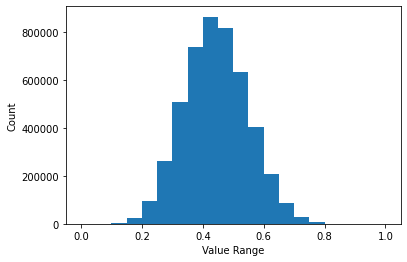

In [31]:
molvec = min_max_normalize(molvec)

molvec_dot = molvec@molvec.T

print(np.max(molvec), np.min(molvec))
print(np.max(molvec_dot), np.min(molvec_dot))

molvec_dot_normalized = (molvec_dot - np.min(molvec_dot)) / (np.max(molvec_dot) - np.min(molvec_dot))

print(np.max(molvec_dot_normalized), np.min(molvec_dot_normalized))

np.savetxt('../MultiView/drug_mol2vec_sim.csv', molvec_dot_normalized, delimiter=',')

plt.hist(molvec_dot_normalized.flatten(), bins=20, range=(0, 1))
plt.xlabel('Value Range')
plt.ylabel('Count')
plt.show()